# Format data

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [115]:
# get data
Data = pd.read_csv("input_data/Climbharder.csv")
Data.columns = Data.columns.str.replace(' ', '_').str.replace('?', '')

## Visualize data

In [116]:
pd.set_option('display.max_columns', None)
Data.head()
print(Data.shape) # 654 items, 35 features
Data.info() # lots of nulls and objects

(654, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 35 columns):
 #   Column                                                                              Non-Null Count  Dtype 
---  ------                                                                              --------------  ----- 
 0   Timestamp                                                                           654 non-null    object
 1   Sex                                                                                 654 non-null    object
 2   Height_(cm)                                                                         654 non-null    object
 3   Weight_(KG)                                                                         654 non-null    object
 4   Arm_Span_(cm)                                                                       651 non-null    object
 5   How_long_have_you_been_climbing_for                                                 654 non-null

<Axes: >

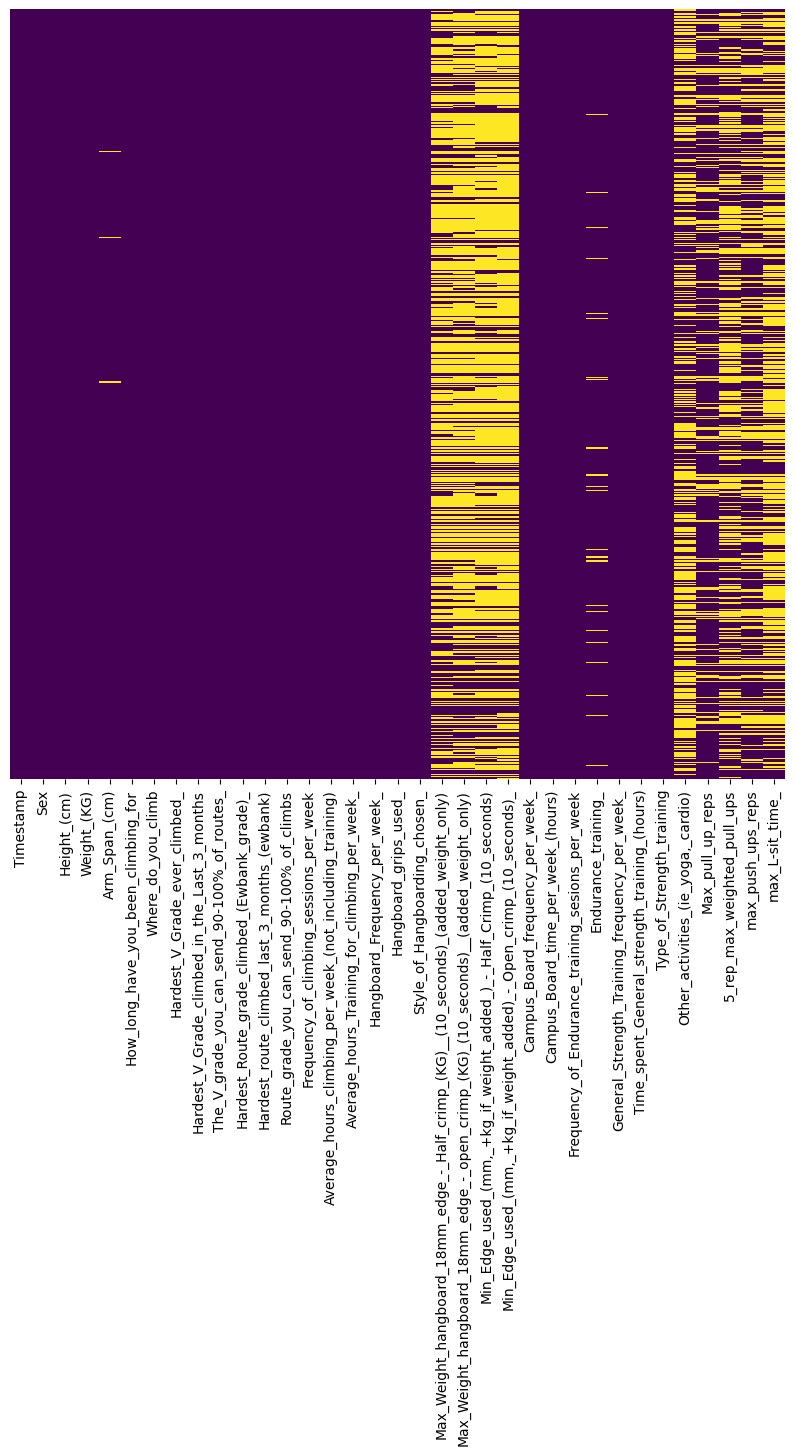

In [117]:
plt.figure(figsize=(10, 10))
sns.heatmap(Data.isna(), yticklabels=False, cbar=False, cmap='viridis') # see null value counts

## Format data

In [118]:
# Change to numeric values
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder

# Categorical values - one choice
categorical_columns = ["Sex", "Where_do_you_climb"]
Data[categorical_columns] = Data[categorical_columns].astype('object')

# List of choices
multi_label_columns = ["Hangboard_grips_used_", "Style_of_Hangboarding_chosen_", "Endurance_training_", "Type_of_Strength_training"]
for col in multi_label_columns:
    Data[col] = Data[col].fillna('').astype(str).str.split(', ')
mlb = MultiLabelBinarizer()
encoded_columns = [pd.DataFrame(mlb.fit_transform(Data[col]), columns=mlb.classes_, index=Data.index) for col in multi_label_columns]
Data = Data.drop(columns=multi_label_columns).join(pd.concat(encoded_columns, axis=1))

# Categorical encoding
onee = OneHotEncoder(drop='if_binary', sparse_output=False)
transform = ColumnTransformer(transformers=[('one-hot', onee, categorical_columns)], remainder='passthrough')

# Fit and transform the data
transformed_data = transform.fit_transform(Data)

# Create a DataFrame with the transformed data
Data = pd.DataFrame(transformed_data, columns=transform.get_feature_names_out())
Data.columns = [col.replace('remainder__', '') for col in Data.columns]
Data.drop(columns=["Other_activities_(ie_yoga,_cardio)"]) # open ended, too many answers. Tokenization in other file
Data.head()

,one-hot__Sex_Male,one-hot__Where_do_you_climb_Indoor Climbing only,one-hot__Where_do_you_climb_Indoor and outdoor climbing,one-hot__Where_do_you_climb_Outdoor Climbing only,Timestamp,Height_(cm),Weight_(KG),Arm_Span_(cm),How_long_have_you_been_climbing_for,Hardest_V_Grade_ever_climbed_,Hardest_V_Grade_climbed_in_the_Last_3_months,The_V_grade_you_can_send_90-100%_of_routes_,Hardest_Route_grade_climbed_(Ewbank_grade)_,Hardest_route_climbed_last_3_months_(ewbank),Route_grade_you_can_send_90-100%_of_climbs,Frequency_of_climbing_sessions_per_week,Average_hours_climbing_per_week_(not_including_training),Average_hours_Training_for_climbing_per_week_,Hangboard_Frequency_per_week_,Max_Weight_hangboard_18mm_edge_-_Half_crimp_(KG)__(10_seconds)_(added_weight_only),Max_Weight_hangboard_18mm_edge_-_open_crimp_(KG)_(10_seconds)__(added_weight_only),"Min_Edge_used_(mm,_+kg_if_weight_added_)_-_Half_Crimp_(10_seconds)","Min_Edge_used_(mm,_+kg_if_weight_added)_-_Open_crimp_(10_seconds)_",Campus_Board_frequency_per_week_,Campus_Board_time_per_week_(hours),Frequency_of_Endurance_training_sesions_per_week,General_Strength_Training_frequency_per_week_,Time_spent_General_strength_training_(hours),"Other_activities_(ie_yoga,_cardio)",Max_pull_up_reps,5_rep_max_weighted_pull_ups,max_push_ups_reps,max_L-sit_time_,Back 2,Back 3,Front 2,Front 3,Full Crimp,Half Crimp,I don't Hangboard,Middle 2,Monos,Open Crimp,Pinch,Slopers,"""no hangs""",I don't hangboard,Max weight,Min Edge,One arm hang program,Other protocol,Repeaters,,4x4,ARC,Feet on 'campusing',I don't train for endurance,Laps of routes,Max moves,hangboard repeater protocols,other,route climbing intervals,systems boards,threshold intervals,Antagonists,Core,Legs,No other strength training,Upper body pulling,Upper body pushing
0,1.0,0.0,1.0,0.0,29/01/2017 20:12:46,173,77,178,4.5 - 5 years,V8,V8,V6,I don't climb routes,I don't climb routes,I don't climb routes,4,8,6,0,0,0,0,0,0,0,1,3,4,NaN,15,29kg,40,30,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0
1,1.0,1.0,0.0,0.0,29/01/2017 20:17:27,180,81,180,3 - 3.5 years,V3,V3,V1,17,I don't climb routes,I don't climb routes,1,3,10,2,NaN,81kg,NaN,NaN,0,0,1,2,2,"Yoga, stretching",11,5kg,24,15sec,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,1,1
2,1.0,0.0,1.0,0.0,29/01/2017 20:28:14,178,67,175,.5 - 1 years,V7,V6,V5,21,21,19,3,4,3,2,25,25,NaN,NaN,0,0,2,3,2,soccer,17,20 kg,NaN,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1
3,1.0,0.0,1.0,0.0,29/01/2017 20:51:08,173,70,178,9 - 9.5 years,V5,V4,V3,21,21,18,2,6,1,1,15,NaN,NaN,NaN,0,0,1,0,0,NaN,8,NaN,30,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,1,1,0,0
4,1.0,0.0,1.0,0.0,29/01/2017 21:03:19,184,84,197,6.5 - 7 years,V10,V10,V7,I don't climb routes,I don't climb routes,I don't climb routes,6,10,2,4,NaN,NaN,8,8,0,0,2,2,1,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1


C:\Users\lucas\AppData\Local\Temp\ipykernel_18664\1906785270.py:29: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  Data['Timestamp'] = pd.to_datetime(Data['Timestamp']).astype(np.int64)


0       6
1      10
2       3
3       1
4       2
       ..
649     6
650     3
651     3
652     2
653     2
Name: Average_hours_Training_for_climbing_per_week_, Length: 654, dtype: object


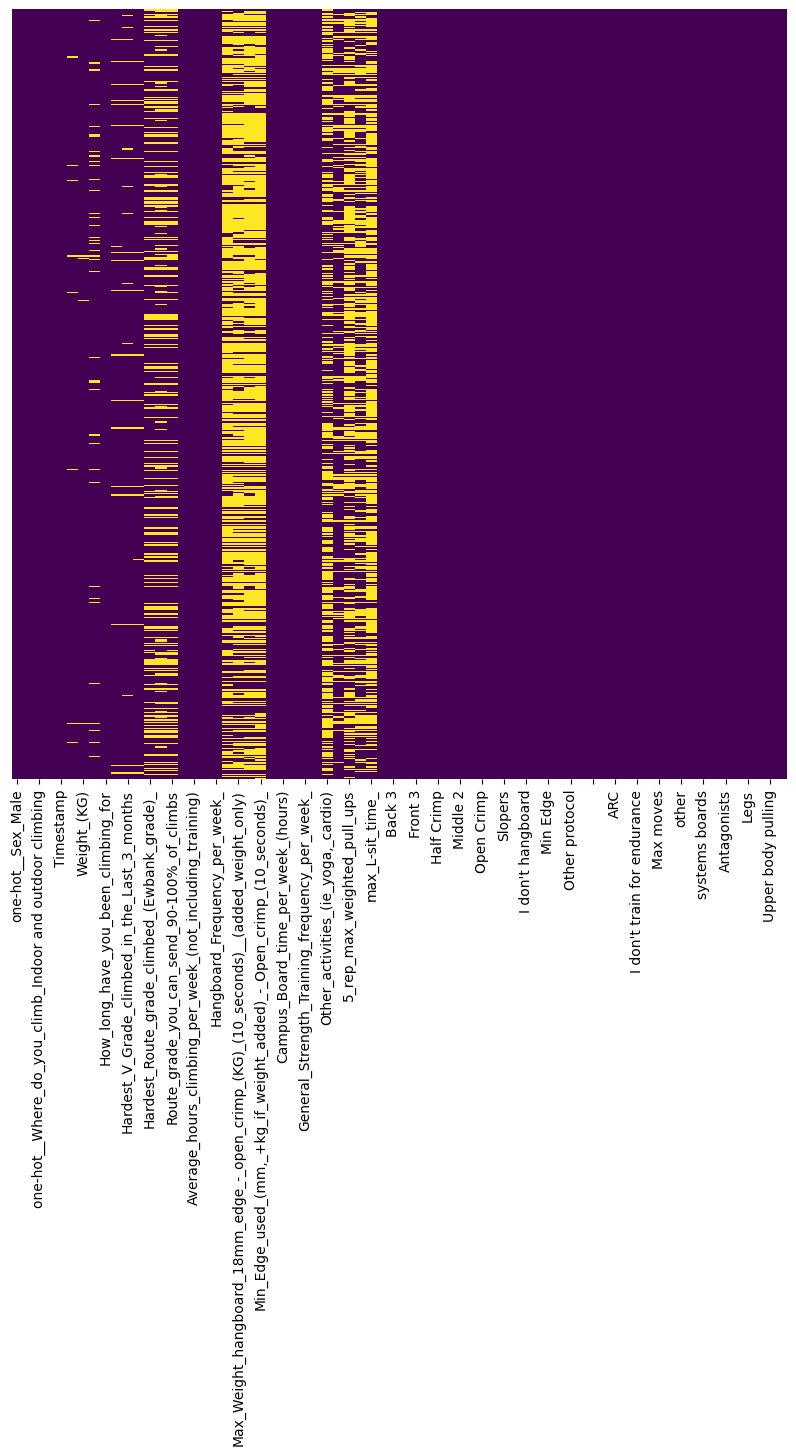

In [119]:
# For integers
def parse_int(height_str, valid_min, valid_max):
    if isinstance(height_str, str):
        try:
            height = int(''.join(filter(str.isdigit, height_str)))
            if valid_min <= height <= valid_max:
                return height
            else:
                return np.nan
        except ValueError:
            return np.nan
    else:
        return np.nan

# For decimals
def parse_float(value_str, valid_min, valid_max):
    if isinstance(value_str, str):
        try:
            value = float(''.join(filter(lambda x: x.isdigit() or x == '.', value_str)))
            if valid_min <= value <= valid_max:
                return value
            else:
                return np.nan
        except ValueError:
            return np.nan
    else:
        return np.nan
    
Data['Timestamp'] = pd.to_datetime(Data['Timestamp']).astype(np.int64)

# Apply the function to the 'Height_(cm)' column
Data['Height_(cm)'] = Data['Height_(cm)'].apply(lambda x: parse_float(x, 100, 300))
Data['Weight_(KG)'] = Data['Weight_(KG)'].apply(lambda x: parse_float(x, 30, 200))
Data['Arm_Span_(cm)'] = Data['Arm_Span_(cm)'].apply(lambda x: parse_float(x, 100, 300))

Data['max_push_ups_reps'] = Data['max_push_ups_reps'].apply(lambda x: parse_int(x, 0, 200))
Data['max_L-sit_time_'] = Data['max_L-sit_time_'].apply(lambda x: parse_float(x, 0, 200))
Data['5_rep_max_weighted_pull_ups'] = Data['5_rep_max_weighted_pull_ups'].apply(lambda x: parse_int(x, 0, 200))

Data['Max_Weight_hangboard_18mm_edge_-_Half_crimp_(KG)__(10_seconds)_(added_weight_only)'] = Data['Max_Weight_hangboard_18mm_edge_-_Half_crimp_(KG)__(10_seconds)_(added_weight_only)'].apply(lambda x: parse_int(x, 0, 200))   

Data['Hardest_V_Grade_ever_climbed_'] = Data['Hardest_V_Grade_ever_climbed_'].apply(lambda x: parse_int(x, 0, 20))
Data['Hardest_V_Grade_climbed_in_the_Last_3_months'] = Data['Hardest_V_Grade_climbed_in_the_Last_3_months'].apply(lambda x: parse_int(x, 0, 20))    
Data['The_V_grade_you_can_send_90-100%_of_routes_'] = Data['The_V_grade_you_can_send_90-100%_of_routes_'].apply(lambda x: parse_int(x, 0, 20)) 
Data['Route_grade_you_can_send_90-100%_of_climbs'] = Data['Route_grade_you_can_send_90-100%_of_climbs'].apply(lambda x: parse_int(x, 0, 50))
Data['Hardest_Route_grade_climbed_(Ewbank_grade)_'] = Data['Hardest_Route_grade_climbed_(Ewbank_grade)_'].apply(lambda x: parse_int(x, 0, 50))
Data['Hardest_route_climbed_last_3_months_(ewbank)'] = Data['Hardest_route_climbed_last_3_months_(ewbank)'].apply(lambda x: parse_int(x, 0, 50))
plt.figure(figsize=(10, 10))
sns.heatmap(Data.isna(), yticklabels=False, cbar=False, cmap='viridis') # see null value counts
print(Data['Average_hours_Training_for_climbing_per_week_'])

In [120]:
# How_long_have_you_been_climbing_for is a range but all start at the same value. 
import re

def first_number(s):
    match = re.search(r'\d+', s)
    if match:
        return str(match.group())
    return None
def parse_time_range(value_str, valid_min, valid_max):
    if isinstance(value_str, str):
        try:
            value_str = first_number(value_str)
            value = float(''.join(filter(lambda x: x.isdigit() or x == '.', value_str)))
            if valid_min <= value <= valid_max:
                return value
            else:
                return np.nan
        except ValueError:
            return np.nan
    else:
        return np.nan
    
Data['How_long_have_you_been_climbing_for'] = Data['How_long_have_you_been_climbing_for'].apply(lambda x: parse_time_range(x, 0, 15))

In [121]:
# save data as csv
Data.to_csv('formatted_data/formatted_data_all.csv', index=False)

In [122]:
threshold = 0.9 * len(Data) # Only use columns with over 90% of the values
Data = Data.dropna(thresh=threshold, axis=1)

# convert to numbers
for col in Data.columns:
    if Data[col].dtype == 'object':
        try:
            Data[col] = pd.to_numeric(Data[col]).astype('float64')
        except ValueError:
            pass

# View data
# Data.info() # all numbers now

In [123]:
# Replace still null values with median
columns_with_nulls = Data.columns[Data.isnull().any()]
Data_with_nulls = Data[columns_with_nulls]
# Data_with_nulls.head() # view which columns still have null values
# Data.info()

<Axes: >

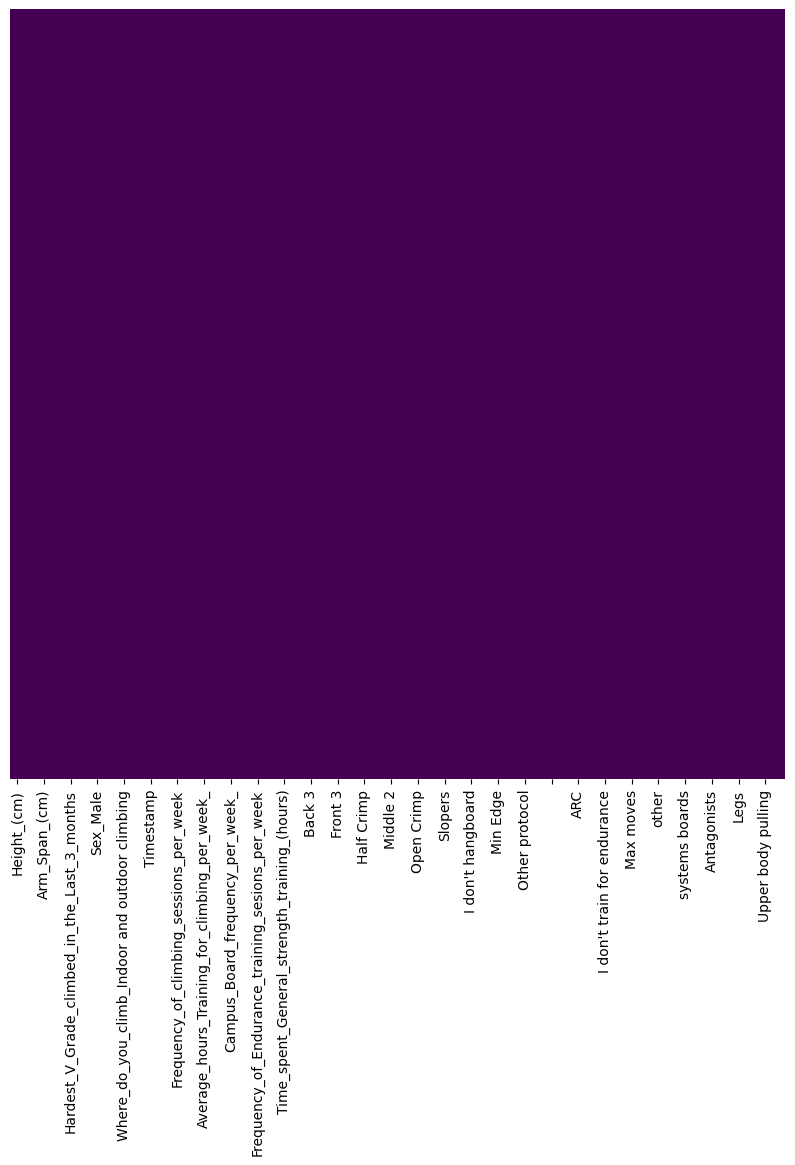

In [129]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer() # default median
median_transform = ColumnTransformer([('imputer', imp, columns_with_nulls)], remainder='passthrough')
median_transform.fit(Data)
Data = pd.DataFrame(median_transform.transform(Data), columns=median_transform.get_feature_names_out())
Data.columns = [col.replace('remainder__', '').replace('imputer__', '').replace('one-hot__', '') for col in Data.columns]
#Data.info()

# No more null values
plt.figure(figsize=(10, 10))
sns.heatmap(Data.isna(), yticklabels=False, cbar=False, cmap='viridis') # see null value counts

In [127]:
# Save image
Data.to_csv('formatted_data/formatted_data.csv', index=False)